In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cmocean as cmo
from scipy.interpolate import griddata

nu = 1.95 * 10 **(-6)

In [3]:
path = 'averagedRuns/'
F1cu1 = pd.read_csv(path + 'f1cu1_ys_body.csv')
F1cu2 = pd.read_csv(path + 'f1cu2_ys_body.csv')
F1cu3 = pd.read_csv(path + 'f1cu3_ys_body.csv')

F2cu1 = pd.read_csv(path + 'f2cu1_ys_body.csv')
F2cu2 = pd.read_csv(path + 'f2cu2_ys_body.csv')
F2cu3 = pd.read_csv(path + 'f2cu3_ys_body.csv')

F3cu1 = pd.read_csv(path + 'f3cu1_ys_body.csv')
F3cu2 = pd.read_csv(path + 'f3cu2_ys_body.csv')
F3cu3 = pd.read_csv(path + 'f3cu3_ys_body.csv')

In [4]:
def buoyancyFreq(rho, y):

    
    # Constants
    g = 9.81  # gravitational acceleration (m/s^2)
    rho_0 = np.nanmean(rho)  # reference density (kg/m^3)

    #new_y = np.linspace(y[0], y[-1], 20)
    #rho = griddata((np.array(y)), np.array(rho), (new_y))
    # Step 1: Handle NaN by interpolation
    #rho = np.interp(new_y, new_y[~np.isnan(rho)], rho[~np.isnan(rho)])

    # Step 2: Compute the vertical density gradient
    min_gradient_threshold = 1e-2 # Adjust based on physical context
    d_rho_dy = np.gradient(rho, y)
    d_rho_dy = np.where(np.abs(d_rho_dy) < min_gradient_threshold, min_gradient_threshold, d_rho_dy)

    # Step 3: Calculate buoyancy frequency squared (N^2)
    N_squared = -(g / rho_0) * d_rho_dy
    N = np.sqrt(N_squared, where=(N_squared >= 0))

    max_N = 100  # Adjust based on the system (e.g., typical oceanography values)
    min_N = 0
    N = np.where(N > max_N, [np.nan], N)
    N = np.where(N < min_N, [np.nan], N)
    
    return N



In [5]:
def drag(body_data):

    nu = 1.95 * 10 **(-6)
    a = body_data
    b = a.iloc[np.where(a.x > 2)[0],:]
    c = b.iloc[np.where(b.y > 0.025)[0],:]
    c = c.sort_values('y')
    c.x = c.x.round(2)
    gb = c.groupby('x')

    xs = gb.groups.keys()
    df = pd.DataFrame(index = xs, columns = ['N','shear','ri'])
    i = 0

    for x in xs:

        ydata = gb.get_group(x).y
        density_data = gb.get_group(x).avgDense
        xVel_data = gb.get_group(x).avg_xVel

        new_y = np.linspace(np.max(ydata)/2, np.max(ydata), 50)
        new_density = griddata((np.array(ydata)), np.array(density_data), (new_y))
        new_xVel = griddata((np.array(ydata)), np.array(xVel_data), (new_y))
        dudy = np.gradient(new_xVel[:], new_y[:])

        N = buoyancyFreq(new_density, new_y)

        if len(N) < 2:
            df.iloc[i,0] = 0
            df.iloc[i,1] = 0
            df.iloc[i,2] = 0
        else:
            df.iloc[i,0] = np.nanmean(N)
            df.iloc[i,1] = np.nanmean(dudy)
            df.iloc[i,2] = df.iloc[i,0]**2 / df.iloc[i,1]
        i = i + 1

    return df

In [6]:
N_f2cu2 = drag(F2cu2)
N_f1cu2 = drag(F1cu2)
N_f3cu2 = drag(F3cu2)

In [7]:
def depthAveraging(data, rOff):

    ## Get only the subglacial
    subglacial_idx = np.where(data.x > 2)[0]
    subglacial = data.iloc[subglacial_idx, :]

    ## Groupby y's and get depth averaged values
    subglacial.x = subglacial.x.round(2)
    gb = subglacial.groupby('x').mean()
    gb = gb.sort_values(by = 'x')
    gb['avg_turbVisc'] = gb['avg_turbVisc'].rolling(window = rOff).mean()
    
    return gb

In [8]:
F1cu1 = depthAveraging(F1cu1, 3)
F1cu2 = depthAveraging(F1cu2, 3)
F1cu3 = depthAveraging(F1cu3, 3)

F2cu1 = depthAveraging(F2cu1, 3)
F2cu2 = depthAveraging(F2cu2, 3)
F2cu3 = depthAveraging(F2cu3, 3)

F3cu1 = depthAveraging(F3cu1, 10)
F3cu2 = depthAveraging(F3cu2, 10)
F3cu3 = depthAveraging(F3cu3, 10)

/var/folders/b0/25x33fpn6_jcyj0hj0v0_qpw02w58x/T/ipykernel_1257/619045667.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subglacial.x = subglacial.x.round(2)
/var/folders/b0/25x33fpn6_jcyj0hj0v0_qpw02w58x/T/ipykernel_1257/619045667.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subglacial.x = subglacial.x.round(2)
/var/folders/b0/25x33fpn6_jcyj0hj0v0_qpw02w58x/T/ipykernel_1257/619045667.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc

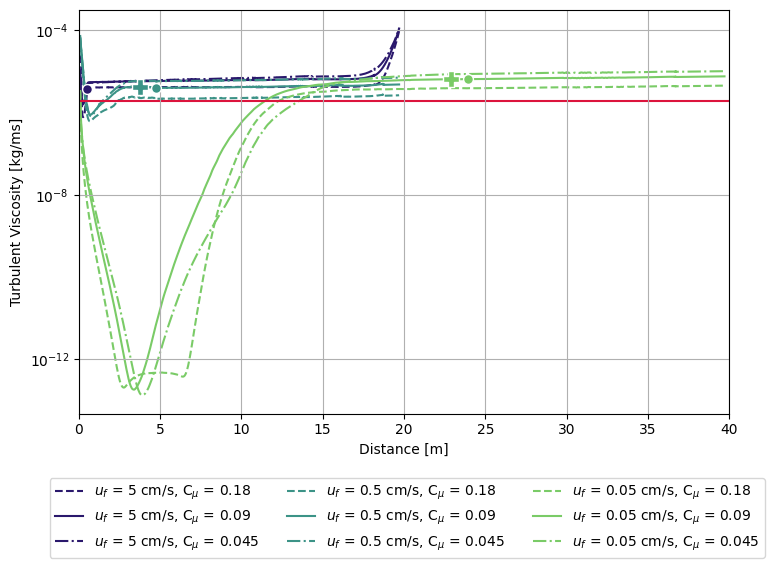

In [12]:
f2cu2_intru = 4.78
f1cu2_intru = 0.49
f3cu2_intru = 23.95

fig, ax = plt.subplots(1, figsize = (8,6))
data = [F1cu1, F1cu2, F1cu3, F2cu1, F2cu2, F2cu3, F3cu1, F3cu2, F3cu3]
intrus = [f1cu2_intru, f1cu2_intru, f1cu2_intru, f2cu2_intru, f2cu2_intru, f2cu2_intru, f3cu2_intru, f3cu2_intru, f3cu2_intru]
labels = ['$u_f$ = 5 cm/s, C$_{\mu}$ = 0.18', '$u_f$ = 5 cm/s, C$_{\mu}$ = 0.09', '$u_f$ = 5 cm/s, C$_{\mu}$ = 0.045',
          '$u_f$ = 0.5 cm/s, C$_{\mu}$ = 0.18', '$u_f$ = 0.5 cm/s, C$_{\mu}$ = 0.09', '$u_f$ = 0.5 cm/s, C$_{\mu}$ = 0.045',
          '$u_f$ = 0.05 cm/s, C$_{\mu}$ = 0.18', '$u_f$ = 0.05 cm/s, C$_{\mu}$ = 0.09', '$u_f$ = 0.05 cm/s, C$_{\mu}$ = 0.045',]

N = ['', N_f1cu2, '', '', N_f2cu2, '', '', N_f3cu2]
n = 3
cT = cmo.cm.haline(np.linspace(0,1,n+2))
colors = [cT[0], cT[0], cT[0], cT[2], cT[2], cT[2], cT[3], cT[3], cT[3]]
linestyles = ['--','-', '-.','--','-', '-.','--','-', '-.']
i = 0
for each in data:



    ax.plot(each.index[10:-30] - 2, each.avg_turbVisc.iloc[10:-30], color = colors[i], linestyle = linestyles[i], label = labels[i],zorder = 1)
    intru = np.argmin(abs(np.array(each.index - 2) - intrus[i]))
    
    if i % 3 == 1:
        idx = np.where(N[i].ri > 0.25)[0][-1]

        ax.scatter(each.index[intru] - 2, each.avg_turbVisc.iloc[intru], color = colors[i],
                s = 50,edgecolor='white',linewidth = 1, zorder = 2)
        
        ax.scatter(each.index[idx] - 2, each.avg_turbVisc.iloc[idx], color = colors[i], marker = 'P',
                s = 125, edgecolor='white', linewidth = 1, zorder = 2)
        
    i = i + 1

ax.plot(np.linspace(0,40,10), np.ones(10) * nu, color = 'crimson', zorder = 1)
ax.set_ylabel('Turbulent Viscosity [kg/ms]'); ax.set_xlabel('Distance [m]')
ax.grid()
ax.legend(loc = 8, bbox_to_anchor = [0.505,-0.375], ncols = 3)
ax.set_yscale('log')
ax.set_yticks([10**(-12), 10**(-8), 10**(-4)])
ax.set_xlim(0, 40)
plt.tight_layout()
plt.savefig('turbViscosity.pdf', dpi = 500)
